**Hypothesis tests** fit into the following framework:
```
1. A test statistic
2. A model of the null hypothesis
3. Analytical method that approximates the p-value
```

In this notebook, instead of using a t-test for the difference between two means, and checking whether all the underlying assumptions are met, I'll be using a `permutation test`.

**Permutation Test**
```
p-value: what are the chances of seeing what we saw by chance?

Steps:
1. Calculate the difference in means between Group-A and Group-B
2. Join Group-A & Group-B into one pot / bucket (shuffle)
3. From the shuffled list, sample (without replacement) a new Group-A* and Group-B*
4. Calculate the new means of Group-A* and Group-B*, and save the difference
5. Do steps 3 – 4, N_SIM times

How many occurances in N_SIM was the new difference as extreme as the original difference? 
- This is your P-value
```

More info can be found on Allen Downey's blog post:
http://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html

In [1]:
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def get_pooled_data(control, treatment):
    """
    Parameters
    ----------
    control  : sequence of real numbers
    treatment: sequence of real numbers
    
    Returns
    -------
    Shuffled pooled data
    """
    
    # Combine Data
    pooled_data = np.hstack([control, treatment])
    
    # Shuffle Data
    np.random.shuffle(pooled_data)
    
    return pooled_data


def get_mean_delta(control, treatment, alternative):
    """
    Parameters
    ----------
    control  : sequence of real numbers
    treatment: sequence of real numbers
    alternative: ['smaller', 'larger', 'two-sided']
    
    Returns
    -------
    Mean Difference between control and treatment
    """
    
    mu_control = np.array(control).mean()
    mu_treatment = np.array(treatment).mean()
    
    if alternative in ['smaller', 'larger']:
        theta_diff = mu_treatment - mu_control
    else:
        theta_diff = np.abs(mu_control - mu_treatment)
        
    return theta_diff


def run_permutation_test(control, treatment, n_samples=1000, alternative='larger'):
    """
    Parameters
    ----------
    control  : sequence of real numbers
    treatment: sequence of real numbers
    n_samples: number of permutations
    alternative: ['smaller', 'larger', 'two-sided']
    
    Returns
    -------
    namedtuple (summary metrics)
    """
    # Observed Difference
    mean_delta = get_mean_delta(control, treatment, alternative) 
    pooled_data = get_pooled_data(control, treatment)
    
    # Number of Scores
    n = pooled_data.size
    # Size of Control Group
    r = np.array(control).size
    total_value = pooled_data.sum()
    
    # Simulated differences under Null Hypothesis
    set_sample_mean_deltas = []
    
    for i in range(n_samples):
        # control sample
        control_sample_sum = np.random.choice(pooled_data, size=r, replace=False).sum()
        control_sample_mean = control_sample_sum / float(r)
        
        # treatment sample
        treatment_sample_sum = total_value - control_sample_sum
        treatment_sample_mean = treatment_sample_sum / float(n - r)
        
        # append result
        set_sample_mean_deltas.append(treatment_sample_mean - control_sample_mean)
        
    if alternative == 'larger':
        # One Sided Test ("larger")
        pval = np.mean([1 if x >= mean_delta else 0 for x in set_sample_mean_deltas])
        
    elif alternative == 'smaller':
        # One Sided Test ("smaller")
        pval = np.mean([1 if x <= mean_delta else 0 for x in set_sample_mean_deltas])
        
    else:
        # Two Sided Test ("two-sided")
        pval = np.mean([1 if abs(x) >= mean_delta else 0 for x in set_sample_mean_deltas])
        
    control_mean = np.array(control).mean()
    treatment_mean = np.array(treatment).mean()
    
    Summary = namedtuple('Summary',
        ['control_mean',
         'treatment_mean',
         'mean_diff',
         'uplift',
         'alternative',
         'permutations',
         'p_value',]
    )
    
    summary = Summary(
        control_mean=round(control_mean,4),
        treatment_mean=round(treatment_mean,4),
        mean_diff=round(mean_delta,4),
        uplift= round(mean_delta / control_mean,4),
        alternative=alternative,
        permutations=round(n_samples,4),
        p_value=round(pval,5)
    )
    
    return summary

### Distributions $\mu_{B}$ vs $\mu_{A}$

In [3]:
control = np.random.normal(loc=54.8, scale=7, size=1_000)
treatment = np.random.normal(loc=55.2, scale=5, size=1_000)

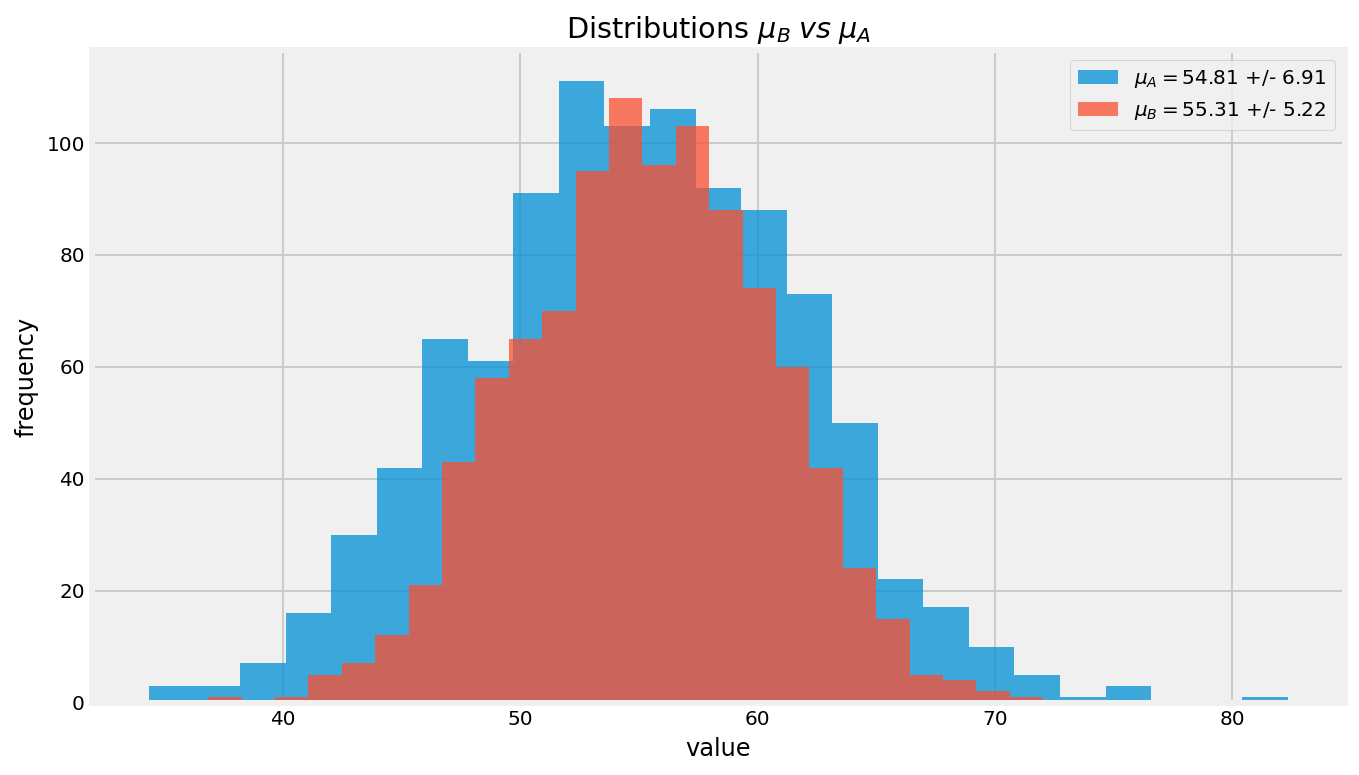

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.hist(
    control, 
    alpha=0.75,
    bins=25,
    label=r'$\mu_{A}=$' + '{:.2f} +/- {:.2f}'.format(control.mean(), control.std())
)

ax.hist(
    treatment, 
    alpha=0.75, 
    bins=25,
    label=r'$\mu_{B}=$' + '{:.2f} +/- {:.2f}'.format(treatment.mean(), treatment.std())
)
ax.set_title(r'Distributions $\mu_{B}\;vs\;\mu_{A}$')
ax.set_xlabel('value')
ax.set_ylabel('frequency')
plt.legend()
plt.show()

### Permutation Test

In [5]:
summary = run_permutation_test(
    control=control,
    treatment=treatment,
    n_samples=1_000,
    alternative='two-sided',
)

summary

Summary(control_mean=54.8117, treatment_mean=55.3053, mean_diff=0.4936, uplift=0.009, alternative='two-sided', permutations=1000, p_value=0.075)

In [6]:
print('control (A): {:.2f}'.format(summary.control_mean))
print('treatment (B): {:.2f}'.format(summary.treatment_mean))
print('uplift (%): {:.2%}'.format(summary.uplift))
print('p_value: {:.3f}'.format(summary.p_value))

control (A): 54.81
treatment (B): 55.31
uplift (%): 0.90%
p_value: 0.075
